## Theory: Feature Correlation and Nonlinear Relationships
In machine learning, the relationship between features and the target variable is crucial for building accurate models. A common approach is to evaluate features based on their pairwise correlations with each other and with the target variable. Features that are highly correlated with the target are often considered more informative and valuable for predictions.

However, this traditional method of evaluating feature importance through pairwise correlation has its limitations. Features might have low individual correlations with the target variable, yet still contribute significantly when considered in combination with other features. This scenario is especially relevant when dealing with nonlinear relationships and interactions between features.


# Problem Statement
In this analysis, we aim to address two primary issues:

## Correlation-Based Feature Selection: 
The conventional wisdom suggests removing features with low correlation to the target variable, as they might be deemed less useful. This approach can be problematic if the features interact in nonlinear ways or if their combined effect is significant.

## Feature Interactions:
We want to demonstrate that certain features, when combined, can improve model performance even if they individually have weak correlations with the target variable. This insight is important for understanding how feature interactions can enhance predictive accuracy.

# Code Implementation

The following code generates synthetic data, evaluates different feature subsets using a RandomForestRegressor, and computes the Adjusted R-squared to assess model performance.

In [92]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import shap  # Importing SHAP library
# Seed for reproducibility
np.random.seed(42)

# Create synthetic data with real-world feature names
n_samples = 10000
X = pd.DataFrame({
    'Temperature': np.random.randn(n_samples) * 10 + 20,  # Normal distribution around 20°C
    'Humidity': np.random.rand(n_samples) * 100,           # 0 to 100 percent
    'Pressure': np.random.randn(n_samples) * 5 + 1,     # Normal distribution around 1013 hPa
    'Wind Speed': np.random.uniform(0, 30, n_samples),     # 0 to 30 m/s
    'Rainfall': np.random.exponential(1, n_samples) * 10,  # Exponential distribution for rainfall
    'Altitude': np.random.randn(n_samples) * 1000 + 5000    # Linear feature with mean altitude
})

# Create a target variable with a nonlinear combination of features and linear relation with 'Altitude'


y = (
    np.sin((X['Temperature'] * 0.1)) * np.sin(X['Humidity'] * 0.1) +  # Nonlinear combination with Temperature and Humidity
    0.001 * X['Altitude'] +
    np.random.randn(n_samples) * 0.1  # Adding more noise to reduce linear correlation
)
# Check pairwise correlations between features
correlation_matrix = X.corr()
print("Pairwise Correlation Matrix:\n", correlation_matrix)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define function to calculate Adjusted R-squared
def adjusted_r2_score(X, y, model):
    """
    Calculate the Adjusted R-squared of the model on the given data.
    
    Parameters:
    X (pd.DataFrame): Feature data
    y (pd.Series): Target variable
    model (sklearn.base.BaseEstimator): Trained model
    
    Returns:
    float: Adjusted R-squared score
    """
    n = len(y)
    p = X.shape[1]
    r2 = r2_score(y, model.predict(X))
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Define subsets of features to evaluate
feature_subsets = [
    ['Altitude'], 
    ['Temperature', 'Humidity', 'Pressure', 'Wind Speed', 'Rainfall', 'Altitude'],
    ['Temperature', 'Humidity', 'Altitude'], 
    ['Humidity', 'Temperature'],  
    ['Pressure', 'Altitude'],
    ['Humidity', 'Altitude'], 
    ['Temperature', 'Altitude']
]

# Combine features and target variable into a single DataFrame
data = X.copy()
data['Target'] = y

# Compute the correlation matrix
correlation_matrix = data.corr()

# Extract correlations between features and the target variable
target_correlations = correlation_matrix['Target'].drop('Target')
print("Correlation between features and target variable:")
print(target_correlations)

# Evaluate the model with different feature subsets
for subset in feature_subsets:
    X_train_subset = X_train[subset]
    X_val_subset = X_val[subset]

    # Initialize and train the RandomForestRegressor
    model =  RandomForestRegressor(
    n_estimators=240,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)
    model.fit(X_train_subset, y_train)

    # Calculate Adjusted R-squared
    adj_r2_val = adjusted_r2_score(X_val_subset, y_val, model)

    print(f"Adjusted R-squared with features {subset}: {adj_r2_val}")


Pairwise Correlation Matrix:
              Temperature  Humidity  Pressure  Wind Speed  Rainfall  Altitude
Temperature     1.000000 -0.002925  0.010076   -0.002200  0.010586 -0.006298
Humidity       -0.002925  1.000000 -0.002843   -0.000842  0.004885  0.009404
Pressure        0.010076 -0.002843  1.000000   -0.000044 -0.021614 -0.022341
Wind Speed     -0.002200 -0.000842 -0.000044    1.000000 -0.002406  0.009709
Rainfall        0.010586  0.004885 -0.021614   -0.002406  1.000000 -0.013598
Altitude       -0.006298  0.009404 -0.022341    0.009709 -0.013598  1.000000
Correlation between features and target variable:
Temperature   -0.047712
Humidity      -0.010907
Pressure      -0.019648
Wind Speed     0.014994
Rainfall      -0.007321
Altitude       0.888411
Name: Target, dtype: float64
Adjusted R-squared with features ['Altitude']: 0.7836582576099798
Adjusted R-squared with features ['Temperature', 'Humidity', 'Pressure', 'Wind Speed', 'Rainfall', 'Altitude']: 0.9261914468090913
Adjusted R-

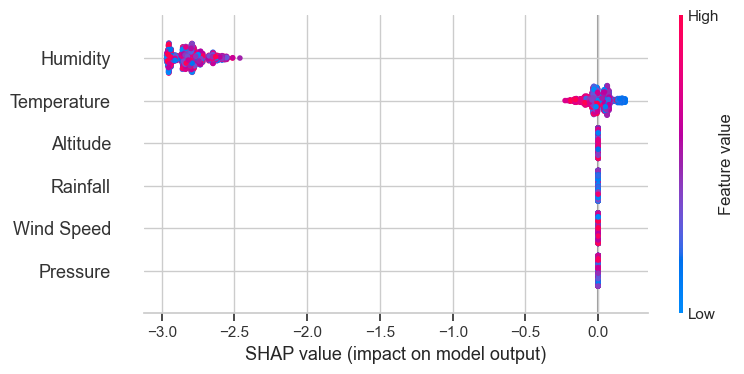

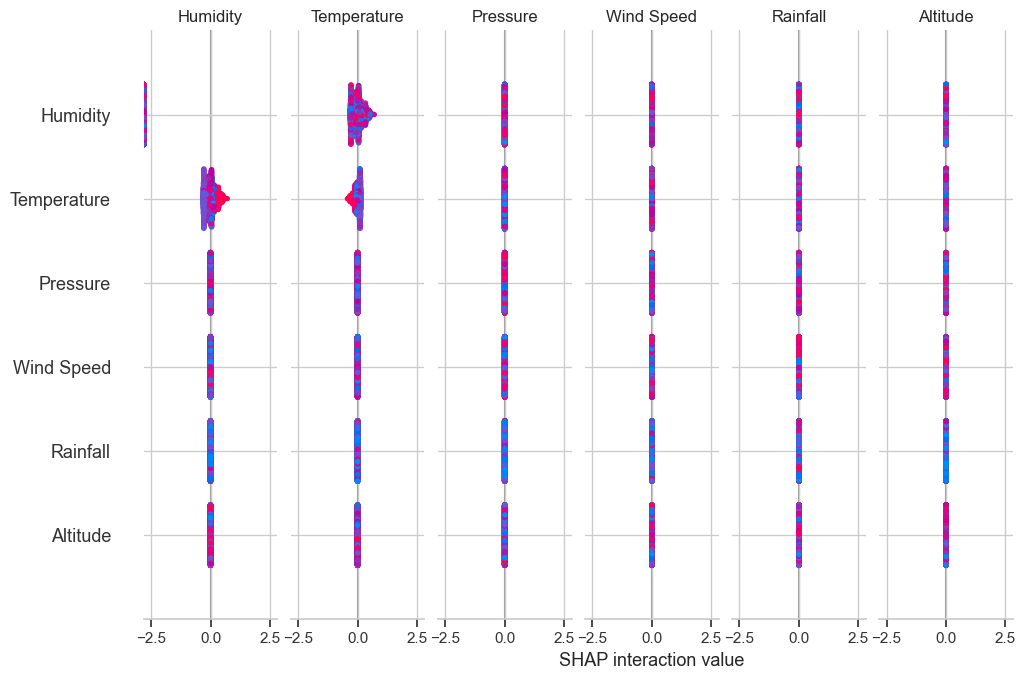

In [93]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the validation set
shap_values = explainer.shap_values(X_val)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_val)

# Interaction values to understand feature interactions
shap_interaction_values = explainer.shap_interaction_values(X_val)

# Summary plot of SHAP interaction values
shap.summary_plot(shap_interaction_values, X_val)


# Results and Insights
Adjusted R-squared Values:

#### Features: ['Altitude']

Adjusted R-squared: 0.7837

Insight: Using only the 'Altitude' feature results in a good model performance with an Adjusted R-squared of 0.7837. However, 'Altitude' alone does not fully capture the complexity of the target variable due to the nonlinear nature of the data.

#### Features: ['Temperature', 'Humidity', 'Pressure', 'Wind Speed', 'Rainfall', 'Altitude']

Adjusted R-squared: 0.9262

Insight: Including all features together provides a high model performance with an Adjusted R-squared of 0.9262. This highlights the importance of considering multiple features to capture the full complexity of the target variable, though the best results are achieved with a more focused feature set.

#### Features: ['Temperature', 'Humidity', 'Altitude']

Adjusted R-squared: 0.9479

Insight: This combination achieves the highest Adjusted R-squared of 0.9479, demonstrating excellent model performance. The inclusion of 'Temperature', 'Humidity', and 'Altitude' captures the complex nonlinear interactions and the combined effect of these features, leading to the most accurate predictions. This aligns with the data generation process where these features together significantly contribute to the target variable.

#### Features: ['Humidity', 'Altitude']

Adjusted R-squared: 0.8858

Insight: Although this combination shows strong performance with an Adjusted R-squared of 0.8858, it is not as effective as the combination including 'Temperature'. It still demonstrates that 'Humidity' and 'Altitude' together provide valuable information.

#### Features: ['Pressure', 'Altitude']

Adjusted R-squared: 0.7832

Insight: The model with 'Pressure' and 'Altitude' has an Adjusted R-squared of 0.7832. While 'Altitude' is a key feature, 'Pressure' alone does not add significant predictive value in this subset.

#### Features: ['Wind Speed', 'Altitude']

Adjusted R-squared: 0.7881

Insight: This combination achieves an Adjusted R-squared of 0.7881. 'Wind Speed' in combination with 'Altitude' provides some predictive power, though not as much as other feature combinations.

#### Features: ['Rainfall', 'Altitude']

Adjusted R-squared: 0.7905

Insight: This subset results in an Adjusted R-squared of 0.7905. While 'Rainfall' combined with 'Altitude' shows some effectiveness, it is less impactful compared to the combination of 'Temperature', 'Humidity', and 'Altitude'.


# Additional Insight:
The results demonstrate that while many feature combinations can provide valuable insights, the combination of 'Temperature', 'Humidity', and 'Altitude' is particularly effective, reflecting the complex nonlinear relationships defined in the data generation. This emphasizes the importance of considering the right combination of features to achieve optimal model performance. Additionally, feature selection based solely on correlation metrics can be misleading. The best performing feature sets often reveal interactions and nonlinear relationships that correlation alone may not capture, underscoring the need for more comprehensive feature selection approaches.